# Modeling of CO Emissions from Cars

## 1 - Data Preprocessing

### 1.1 - Data Cleaning

First we read the csv file

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

# read dataset file

df = pd.read_csv('Euro_6_latest.csv', delimiter=',', encoding="ISO-8859-1")

# Remove a funny column called Unnamed
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop any column with all values are na
df = df.dropna(how='all',axis='columns').copy()

# Remove features with more than 70% missing values
limitPer = len(df) * .70
df = df.dropna(thresh=limitPer, axis=1).copy()


# drop unnecessary columns
df = df.drop(['Transmission','Euro Standard','Testing Scheme','Date of change','WLTP Imperial Low',
               'WLTP Imperial Medium','WLTP Imperial High','WLTP Imperial Extra High',
               'WLTP Imperial Combined','WLTP Imperial Combined (Weighted)' ,
                'Diesel VED Supplement','Emissions NOx [mg/km]',
               'THC Emissions [mg/km]','Noise Level dB(A)'], axis=1).copy()
df.shape

(4657, 18)

#### Next we merge low-level categories to upper-level categories

#### -Dropping Unnecessary Columns
We need to explain why we dropping those fields. I will add the reason later.

The dataset has the following emissions:<br/>
Emissions CO [mg/km] <br/>
THC Emissions [mg/km]<br/>
Emissions NOx [mg/km]<br/>
Noise Level dB(A)<br/>

We are going to use a single output Emissions CO [mg/km] as y value and drop the rest.

In [3]:
print(df['Manual or Automatic'].unique(),'\n')
print(df['Fuel Type'].unique(),'\n')
print(df['Powertrain'].unique())

['Manual' 'Automatic' 'Electric - Not Applicable'] 

['Petrol' 'Diesel' 'Electricity / Petrol' 'Petrol Electric' 'Electricity'
 'Petrol / LPG' 'Diesel Electric' 'Electricity / Diesel'] 

['Internal Combustion Engine (ICE)'
 'Plug-in Hybrid Electric Vehicle (PHEV)'
 'Mild Hybrid Electric Vehicle (MHEV)'
 'Battery Electric Vehicle (BEV) / Pure Electric Vehicle / Electric Vehicle (EV)'
 'Hybrid Electric Vehicle (HEV)' 'Micro Hybrid']


#### -Grouping to Higher-Level Categories
We have 6 categorical featuers (object type)

We summerised Manufacturer and Model into higher-level column category called 'Model Type'

In [4]:
# Create a new column 'Transmission', assign it a value of Automatic where the 
# first character of Transmission is A
# or Manual if the first letter is M or Electric if first letter is E 
AUTOMATIC = "Automatic"
MANUAL = "Manual"
ELECTRIC = "Electric"
df.loc[df['Manual or Automatic'].str.startswith('A'),'Transmission'] = AUTOMATIC
df.loc[df['Manual or Automatic'].str.startswith('M'),'Transmission'] = MANUAL
df.loc[df['Manual or Automatic'].str.startswith('E'),'Transmission'] = ELECTRIC

In [5]:
# Combine those into 4 main types pertrol, diesel, hybrid, electric
# Petrol, Petrol / LPG --> Petrol
# Diesel --> Diesel
# Electricity --> Electric
# Electricity / Petrol, Petrol Electric, Diesel Electric, Electricity / Diesel ---> hybrid

pertrol = ['Petrol','Petrol / LPG']
diesel = ['Diesel']
electric = ['Electricity']
hybrid = ['Electricity / Petrol','Petrol Electric','Diesel Electric','Electricity / Diesel']
#df = df.copy()
df.loc[df['Fuel Type'].isin(pertrol), 'Fuel'] = 'Petrol'
df.loc[df['Fuel Type'].isin(diesel), 'Fuel'] = 'Diesel'
df.loc[df['Fuel Type'].isin(electric), 'Fuel'] = 'Electric'
df.loc[df['Fuel Type'].isin(hybrid), 'Fuel'] = 'Hybrid'

In [6]:
ice = ['Internal Combustion Engine (ICE)']
hybrid = ['Plug-in Hybrid Electric Vehicle (PHEV)',
          'Mild Hybrid Electric Vehicle (MHEV)',
          'Hybrid Electric Vehicle (HEV)','Micro Hybrid']
ev = ['Battery Electric Vehicle (BEV) / Pure Electric Vehicle / Electric Vehicle (EV)']

df.loc[df['Powertrain'].isin(ice), 'PT'] = 'ICE'
df.loc[df['Powertrain'].isin(ev), 'PT'] = 'EV'
df.loc[df['Powertrain'].isin(hybrid), 'PT'] = 'Hybrid'

In [7]:
# Drop the old columns
df = df.drop(['Powertrain','Fuel Type','Manual or Automatic'], axis=1)

In [8]:
# Rename PT back to Powertrain
df.rename(columns={'PT':'Powertrain'}, inplace=True)

In [9]:
# Check missing values in each remaining column
for (columnName, columnData) in df.iteritems():
   print(columnName, ' Num of empty cells : ', columnData.isnull().sum())

Manufacturer  Num of empty cells :  0
Model  Num of empty cells :  0
Description  Num of empty cells :  0
Engine Capacity  Num of empty cells :  2
Engine Power (PS)  Num of empty cells :  221
Engine Power (Kw)  Num of empty cells :  89
WLTP Metric Low  Num of empty cells :  5
WLTP Metric Medium  Num of empty cells :  5
WLTP Metric High  Num of empty cells :  5
WLTP Metric Extra High  Num of empty cells :  6
WLTP Metric Combined  Num of empty cells :  15
WLTP Metric Combined (Weighted)  Num of empty cells :  1000
WLTP CO2  Num of empty cells :  2
WLTP CO2 Weighted  Num of empty cells :  1209
Emissions CO [mg/km]  Num of empty cells :  108
Transmission  Num of empty cells :  0
Fuel  Num of empty cells :  0
Powertrain  Num of empty cells :  0


C:\Users\keyma\AppData\Local\Temp\ipykernel_8128\2844268483.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in df.iteritems():


In [10]:
# Engine Capacity missing the value for Electic cars (not applicable). So, we replace those with zero
df['Engine Capacity'] = df['Engine Capacity'].fillna(0)


In [11]:
# We use ffill (forward filling) and bfill (backward filling) per group to fill the missing 
# values of Engine Power (PS). We group by car manufacturer and Model
df['Engine Power (PS)'] = df.groupby(['Manufacturer','Model'], sort=False)['Engine Power (PS)'].apply(lambda x: x.ffill().bfill())

C:\Users\keyma\AppData\Local\Temp\ipykernel_8128\956999121.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['Engine Power (PS)'] = df.groupby(['Manufacturer','Model'], sort=False)['Engine Power (PS)'].apply(lambda x: x.ffill().bfill())


In [12]:
# Same with Engine Power (Kw)
df['Engine Power (Kw)'] = df.groupby(['Manufacturer','Model'], sort=False)['Engine Power (Kw)'].apply(lambda x: x.ffill().bfill())

C:\Users\keyma\AppData\Local\Temp\ipykernel_8128\3635275803.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['Engine Power (Kw)'] = df.groupby(['Manufacturer','Model'], sort=False)['Engine Power (Kw)'].apply(lambda x: x.ffill().bfill())


In [13]:
# Count how many zeros in WLTP Metric Combined (Weighted) and WLTP CO2 Weighted columns
print('WLTP Metric Combined (Weighted) zeros =', len(df) - np.count_nonzero(df["WLTP Metric Combined (Weighted)"]))
print('WLTP CO2 Weighted zeros =', len(df) - np.count_nonzero(df["WLTP CO2 Weighted"]))


WLTP Metric Combined (Weighted) zeros = 3472
WLTP CO2 Weighted zeros = 3098


In [14]:
# There are too many zeros values in both columns. So we are going to drop those 2 columns
df = df.drop(['WLTP Metric Combined (Weighted)','WLTP CO2 Weighted'], axis=1).copy()

In [15]:
# we going to fill missing values with mean of each column
# We did not replace 0 values because that is not correct, for example electric cars may have 0 CO emissions
df['WLTP Metric Combined'].fillna((df['WLTP Metric Combined'].mean()), inplace=True)
df['WLTP Metric Low'].fillna((df['WLTP Metric Low'].mean()), inplace=True)
df['WLTP Metric Medium'].fillna((df['WLTP Metric Medium'].mean()), inplace=True)
df['WLTP Metric High'].fillna((df['WLTP Metric High'].mean()), inplace=True)
df['WLTP Metric Extra High'].fillna((df['WLTP Metric Extra High'].mean()), inplace=True)
df['WLTP CO2'].fillna((df['WLTP CO2'].mean()), inplace=True)
df['Emissions CO [mg/km]'].fillna((df['Emissions CO [mg/km]'].mean()), inplace=True)
df.isnull().sum(axis = 0)

Manufacturer                0
Model                       0
Description                 0
Engine Capacity             0
Engine Power (PS)         177
Engine Power (Kw)          89
WLTP Metric Low             0
WLTP Metric Medium          0
WLTP Metric High            0
WLTP Metric Extra High      0
WLTP Metric Combined        0
WLTP CO2                    0
Emissions CO [mg/km]        0
Transmission                0
Fuel                        0
Powertrain                  0
dtype: int64

In [16]:
# Last step to drop rows with na values
df = df.dropna().copy()


In [17]:
# Lets look at the result df and see how many categorical features we have
for column in df:
    print("{} | {} | {}".format(
        df[column].name, len(df[column].unique()), df[column].dtype
    ))

Manufacturer | 40 | object
Model | 305 | object
Description | 2138 | object
Engine Capacity | 88 | float64
Engine Power (PS) | 196 | float64
Engine Power (Kw) | 179 | float64
WLTP Metric Low | 240 | float64
WLTP Metric Medium | 168 | float64
WLTP Metric High | 132 | float64
WLTP Metric Extra High | 138 | float64
WLTP Metric Combined | 146 | float64
WLTP CO2 | 246 | float64
Emissions CO [mg/km] | 422 | float64
Transmission | 3 | object
Fuel | 4 | object
Powertrain | 3 | object


### 1.2 - Data Exploration

C:\Users\keyma\AppData\Local\Temp\ipykernel_8128\1321095847.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


C:\Users\keyma\AppData\Local\Temp\ipykernel_8128\1321095847.py:9: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  df1.groupby(['Manufacturer','Fuel']).size().unstack().plot(sort_columns='Manufacturer',


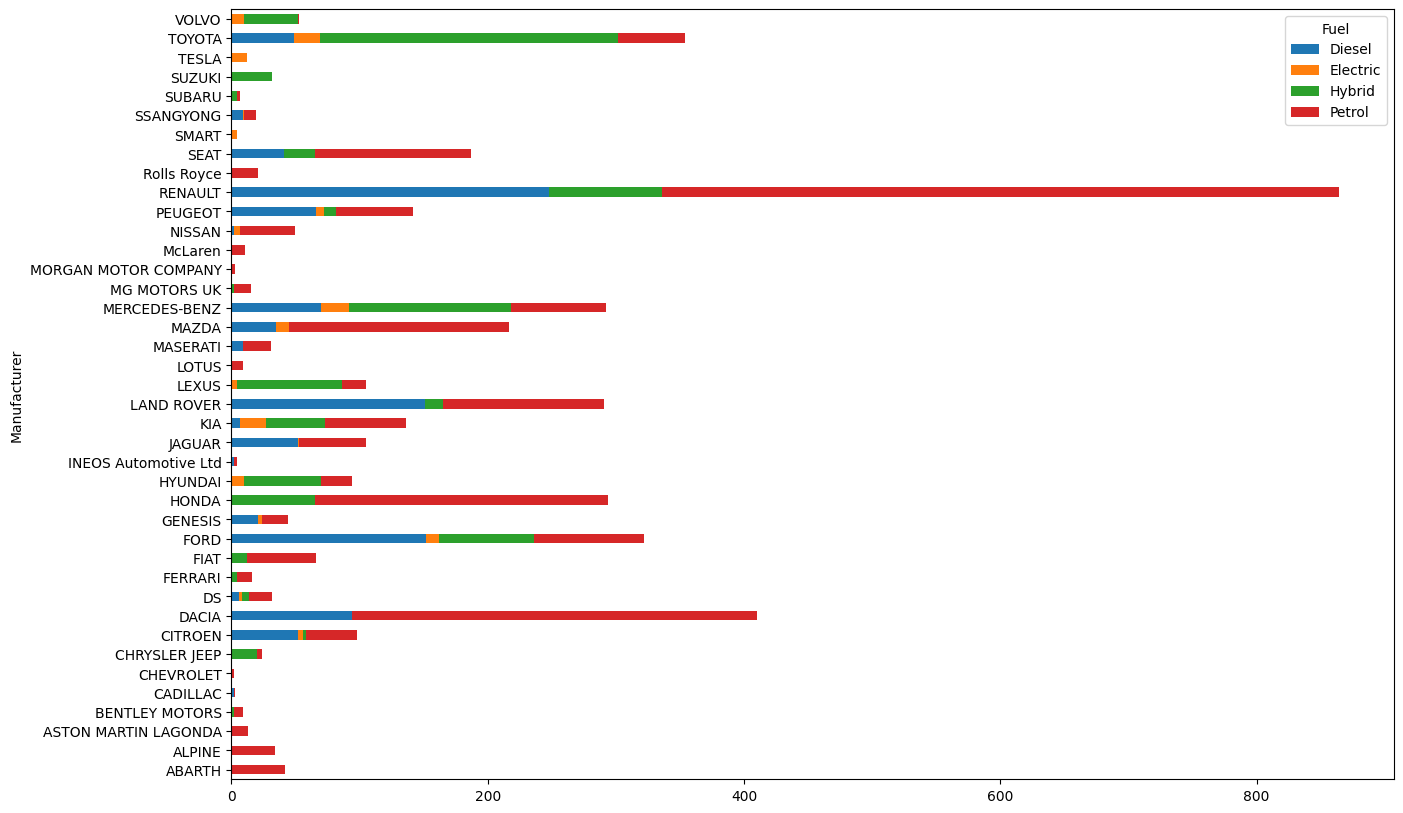

In [18]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))
# Total cars by car manufacturers
plt.rcParams["figure.figsize"] = (15,10)
cols = ['Manufacturer', 'Fuel']
df1 = df[cols].copy()


df1.groupby(['Manufacturer','Fuel']).size().unstack().plot(sort_columns='Manufacturer',
        kind='barh', stacked=True,width=0.5,linewidth=0.5);




Text(0.5, 0, 'Manufacturer')

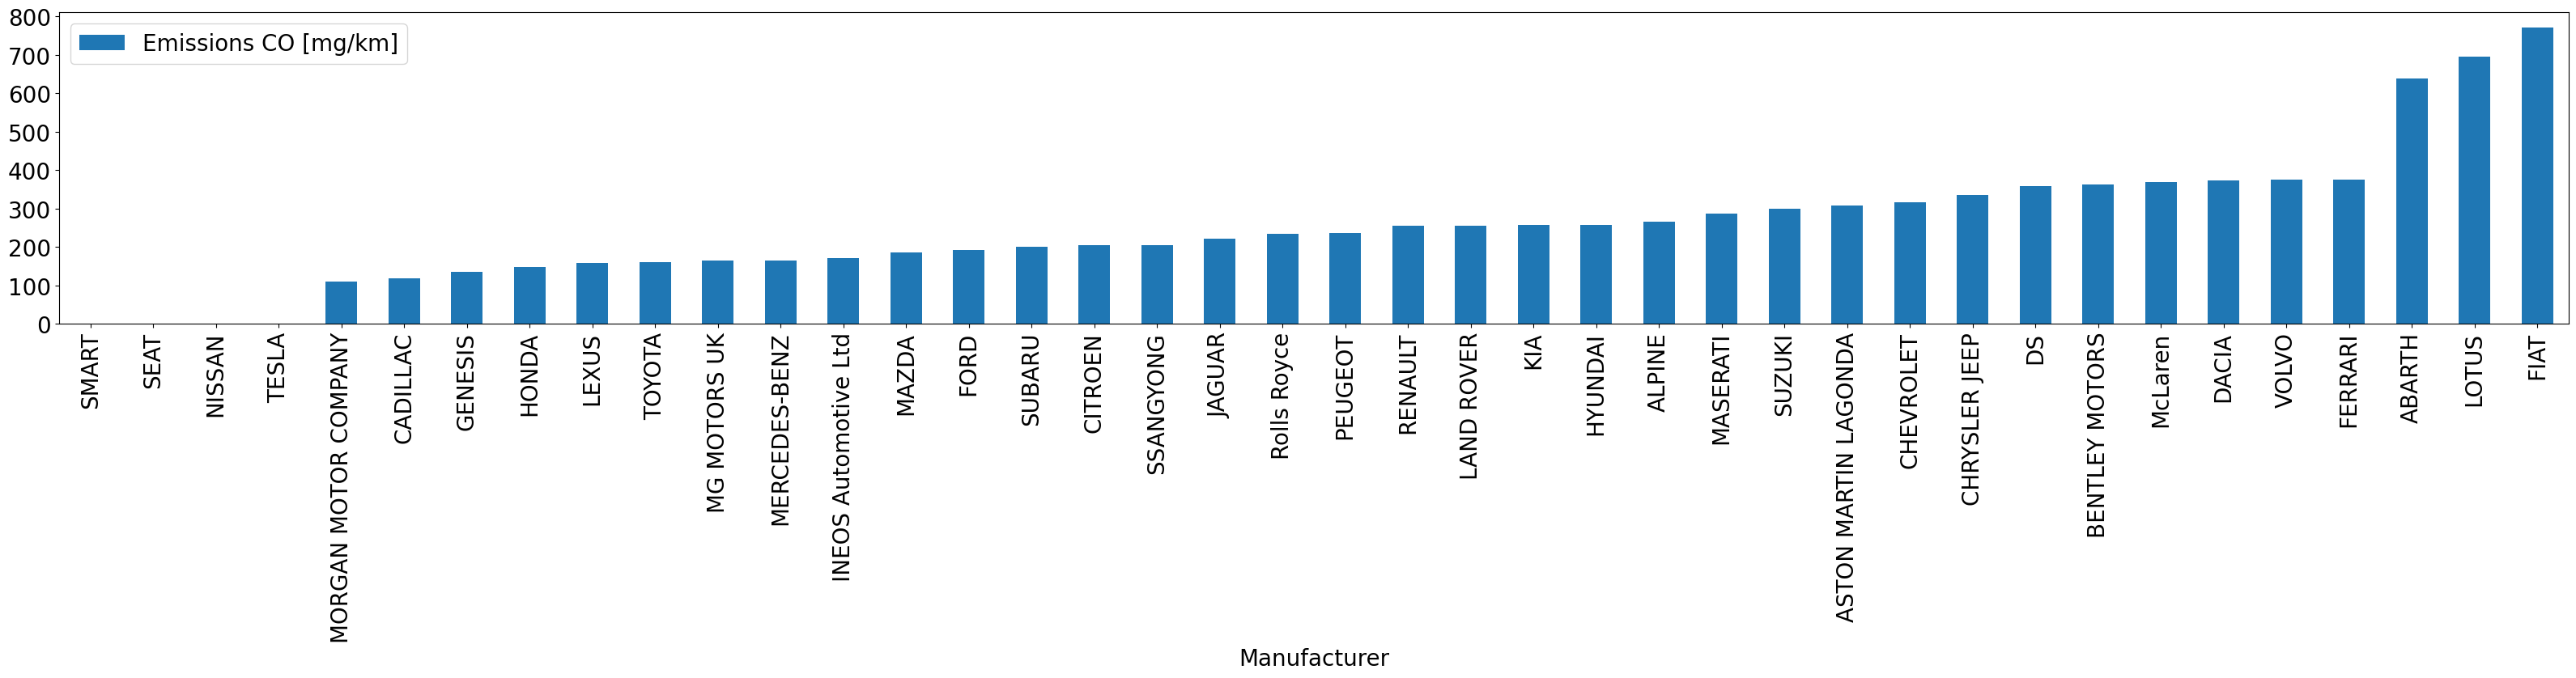

In [19]:
cols = ['Manufacturer', 'Emissions CO [mg/km]']
plt.rcParams["figure.figsize"] = (40,5)

df2 = df[cols].copy()
df2 = df2.groupby('Manufacturer', as_index=False)['Emissions CO [mg/km]'].mean()

df2.sort_values('Emissions CO [mg/km]',inplace=True)
df2.plot(kind='bar',x='Manufacturer',y='Emissions CO [mg/km]',fontsize=20)
plt.legend(fontsize = 20)
plt.xlabel('Manufacturer', fontsize=20)

##### Note: Nissan CO Emission figures are recorded as zero in the original dataset. 

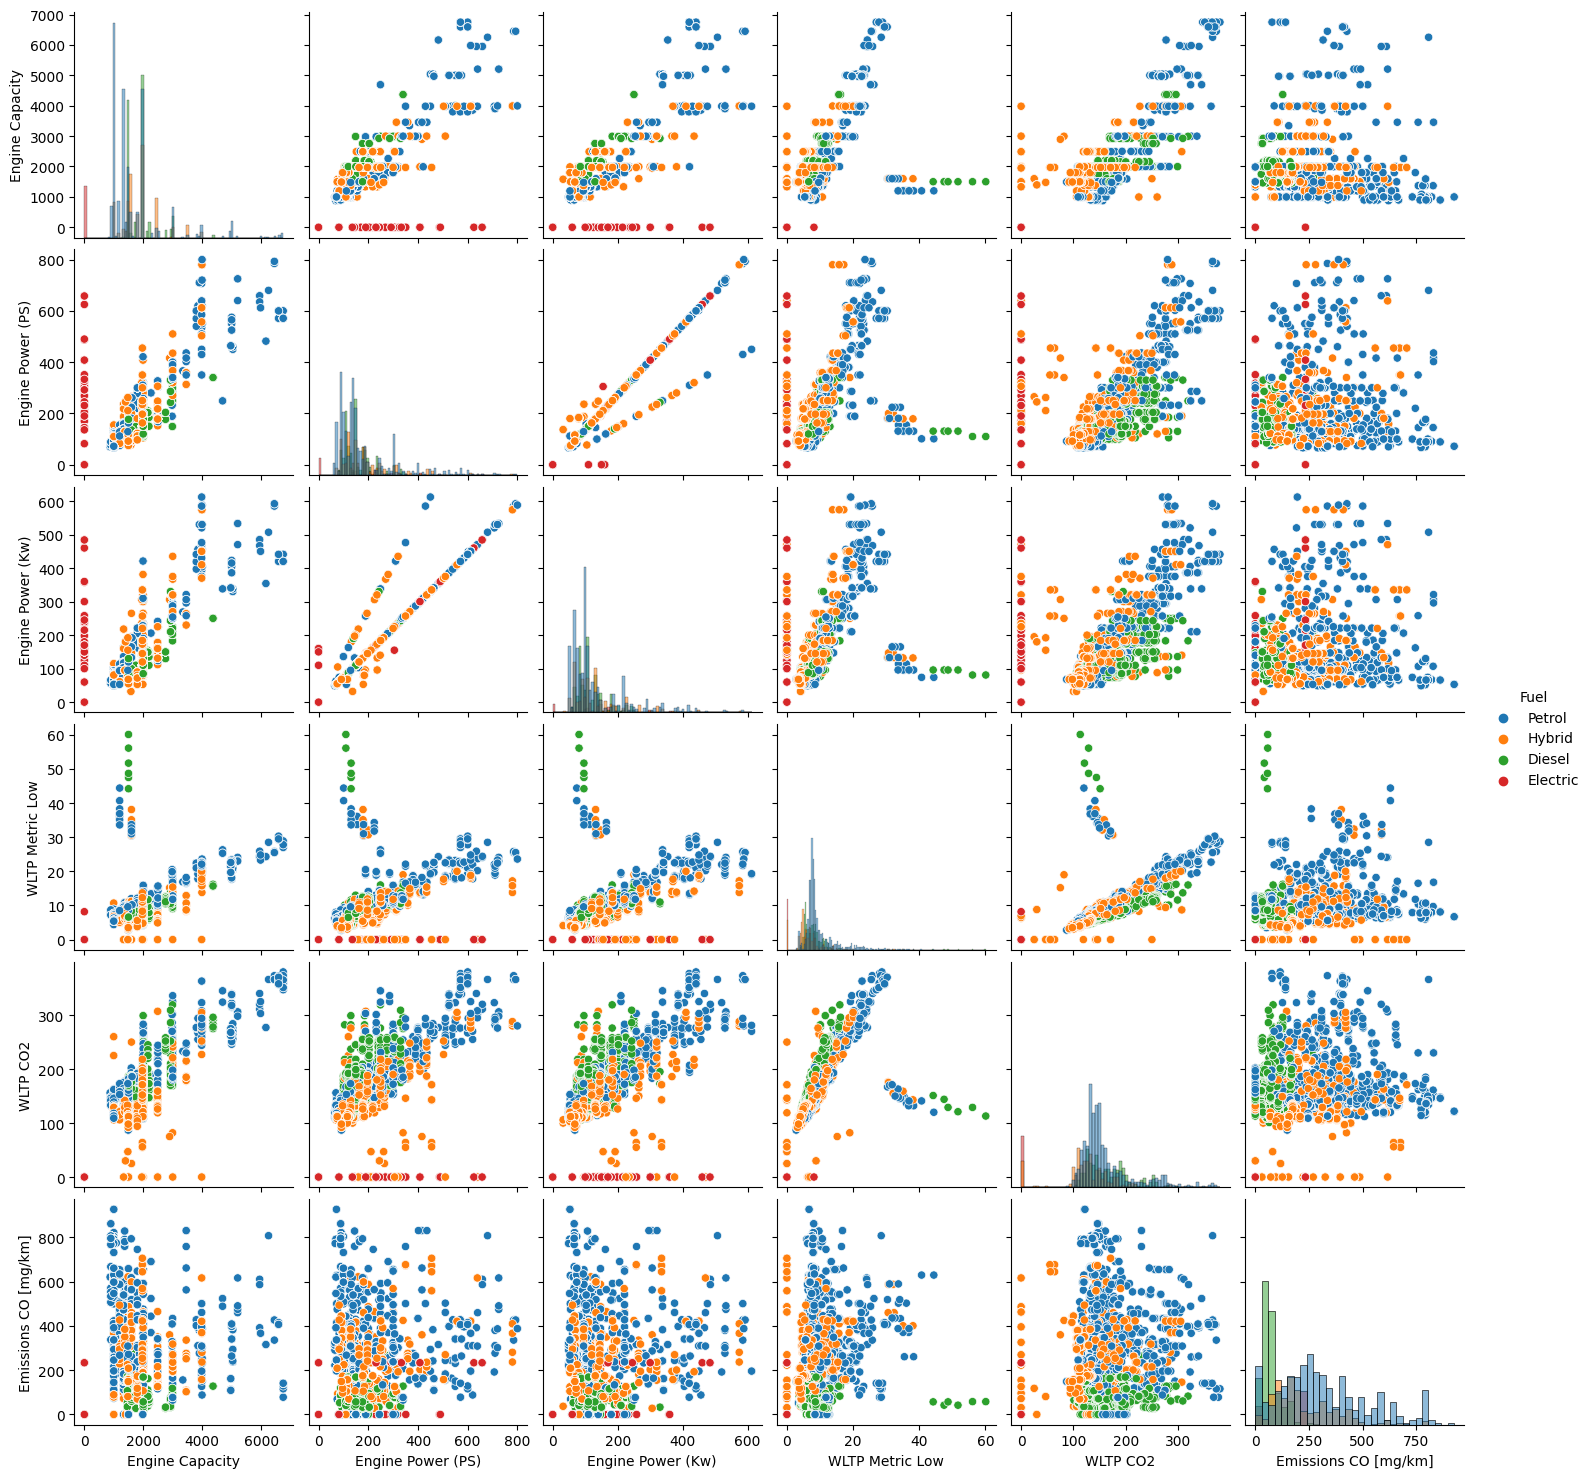

In [20]:
sns.pairplot(df,vars=['Engine Capacity','Engine Power (PS)','Engine Power (Kw)',
                      'WLTP Metric Low','WLTP CO2',
                      'Emissions CO [mg/km]'],hue='Fuel',
                       diag_kind='hist')

In [21]:
df.describe().transpose()[['mean', 'std']]
# Note how each feature covers a very different range, therefore we need to normalise the dataset

,mean,std
Engine Capacity,1744.287665,894.872988
Engine Power (PS),175.893217,109.439872
Engine Power (Kw),131.782628,83.890608
WLTP Metric Low,8.307146,4.909390
WLTP Metric Medium,6.399704,4.837777
WLTP Metric High,5.861178,4.419764
WLTP Metric Extra High,7.056735,3.763594
WLTP Metric Combined,6.737001,4.058259
WLTP CO2,151.679009,57.911991
Emissions CO [mg/km],232.946411,197.198821


# Encoding

In [22]:
# We are using get_dummies() for encoding
dummy_cols = ['Transmission','Fuel','Powertrain']
df_encode = pd.get_dummies(df, columns=dummy_cols).copy()

# Manufacturer, Model and Description are dropped because they are strings and irrelevant for the prediction of the target value.
df_encode = df_encode.drop(['Manufacturer', 'Model','Description'], axis=1).copy()

In [23]:
# First thing we want to do is see what data types we have:
df_encode.dtypes

Engine Capacity           float64
Engine Power (PS)         float64
Engine Power (Kw)         float64
WLTP Metric Low           float64
WLTP Metric Medium        float64
WLTP Metric High          float64
WLTP Metric Extra High    float64
WLTP Metric Combined      float64
WLTP CO2                  float64
Emissions CO [mg/km]      float64
Transmission_Automatic      uint8
Transmission_Electric       uint8
Transmission_Manual         uint8
Fuel_Diesel                 uint8
Fuel_Electric               uint8
Fuel_Hybrid                 uint8
Fuel_Petrol                 uint8
Powertrain_EV               uint8
Powertrain_Hybrid           uint8
Powertrain_ICE              uint8
dtype: object

### -Identify the Input and target variables
Our target variable is 'Emissions CO [mg/km]'

# Splitting the Data

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


scaler.fit(df_encode)
scaled_features = scaler.transform(df_encode) # Values in the dataframe are converted into the scale of 0-1 to fit training on SVMs.

df_scaled = pd.DataFrame(scaled_features, columns = df_encode.columns) # The new dataframe stored the values after conversion.
print(df_scaled)

      Engine Capacity  Engine Power (PS)  Engine Power (Kw)  WLTP Metric Low  \
0            0.202697            0.18125           0.174837         0.171381   
1            0.202697            0.18125           0.174837         0.173045   
2            0.202697            0.18125           0.174837         0.171381   
3            0.202697            0.18125           0.174837         0.173045   
4            0.202697            0.18125           0.174837         0.158070   
...               ...                ...                ...              ...   
4462         0.291747            0.31250           0.300654         0.227953   
4463         0.291747            0.31250           0.300654         0.204659   
4464         0.291747            0.56875           0.547386         0.000000   
4465         0.291747            0.56875           0.547386         0.000000   
4466         0.291747            0.56875           0.547386         0.000000   

      WLTP Metric Medium  WLTP Metric H

In [25]:
X_2 = df_scaled.loc[:, df_scaled.columns != 'Emissions CO [mg/km]']

m = df_encode['Emissions CO [mg/km]'].mean() # Mean of the target value.

# The target value is divided into two classes. Those above its mean are 0 and considered as high. 
# On the other hands, those below its mean are 1 and considered as low.
y_2 = (df_encode['Emissions CO [mg/km]'] <= m).astype('int64') 

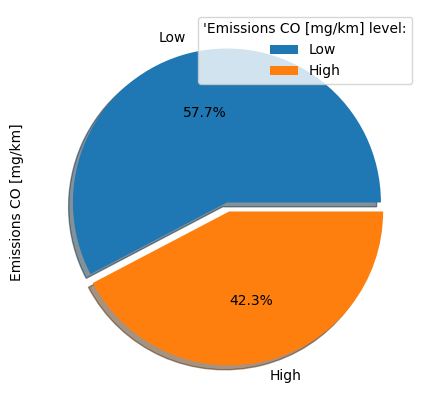

In [26]:
y_2.value_counts() / y_2.count()
y_labels = ["Low", "High"]
y_2.value_counts().plot.pie(explode=[0, 0.06], figsize=(5,5), labels = y_labels, autopct = '%1.1f%%', shadow=True)
plt.legend(title = "'Emissions CO [mg/km] level:") # The pie plot shows proportion of each class of the target value.

In [27]:
# The code below reconfirms classification for the target value is correct. First 100 rows are used.

for i in df_encode.index:
    print(y_2[i], df_encode['Emissions CO [mg/km]'][i])
    if (i > 100):
        break

0 760.0
0 760.0
0 760.0
0 760.0
0 829.0
0 829.0
0 493.0
0 493.0
0 561.0
0 561.0
0 493.0
0 493.0
0 421.0
0 600.0
0 600.0
0 421.0
0 561.0
0 561.0
0 781.0
0 781.0
0 791.0
0 791.0
0 791.0
0 791.0
0 576.0
0 576.0
0 576.0
0 576.0
0 781.0
0 781.0
0 534.0
0 534.0
0 781.0
0 781.0
0 534.0
0 534.0
0 781.0
0 781.0
0 421.0
0 600.0
0 421.0
0 600.0
1 204.0
1 204.0
1 204.0
1 204.0
1 212.0
0 275.0
1 212.0
1 212.0
0 549.0
0 549.0
0 281.0
0 281.0
1 230.0
0 281.0
0 549.0
0 549.0
1 230.0
0 281.0
1 216.0
1 216.0
1 216.0
1 216.0
1 229.0
1 229.0
1 229.0
1 229.0
1 229.0
1 229.0
1 229.0
1 229.0
1 204.0
1 204.0
1 216.0
1 216.0
1 155.0


In [48]:
# Split train set and test set into 80% to 20%.
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=.2, random_state = 125)

In [49]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


svm_1 = svm.SVC(kernel='linear') # Create a SVM classifier and use linear as kernel as it is the most common one. 

svm_1.fit(X_train_2, y_train_2) # Train the SVM model.

y_pred_2 = svm_1.predict(X_test_2) # Make prediction from the test set.

accuracies = cross_val_score(svm_1, X_train_2, y_train_2, cv=10) # Accuracies of the model. 10-fold cross validation is used here.


print("Train Score:", np.mean(accuracies)) 
print("Test Score:", svm_1.score(X_test_2, y_test_2))
print("Accuracy:", accuracy_score(y_test_2, y_pred_2))
print("confusion_matrix:", confusion_matrix(y_test_2, y_pred_2))

Train Score: 0.7718847315462497
Test Score: 0.7651006711409396
Accuracy: 0.7651006711409396
confusion_matrix: [[317  60]
 [150 367]]


In [50]:
# GridSearchCV is used here to search the best parameters for the SVM model. The training process is similar as above.

grid = {
    'C':[0.01, 0.1 ,1, 10],
    'kernel' : ["linear", "poly", "rbf", "sigmoid"],
    'degree' : [1, 3, 5, 7],
    'gamma' : [0.01, 1]
}

svm_2  = SVC(random_state = 125)
svm_cv = GridSearchCV(svm_2, grid, cv = 10)
svm_cv.fit(X_train_2, y_train_2)


# With the new parameters, both train score and test score have improved from the model trained earlier.
print("Best Parameters:", svm_cv.best_params_)
print("Train Score:", svm_cv.best_score_)
print("Test Score:", svm_cv.score(X_test_2, y_test_2))


Best Parameters: {'C': 10, 'degree': 7, 'gamma': 1, 'kernel': 'poly'}
Train Score: 0.875736663380436
Test Score: 0.8657718120805369


In [54]:
grid_predictions = svm_cv.predict(X_test_2)

print(classification_report(y_test_2, grid_predictions)) # Classification report.

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       377
           1       0.92      0.84      0.88       517

    accuracy                           0.87       894
   macro avg       0.86      0.87      0.86       894
weighted avg       0.87      0.87      0.87       894



In [56]:
# Below reconfirms the new model is better in accuracy.

svm_3 = SVC(kernel='poly', degree=7, gamma=1, C=10)
svm_3.fit(X_train_2, y_train_2)
y_pred_2_1 = svm_3.predict(X_test_2)


print("Accuracy:", accuracy_score(y_test_2, y_pred_2_1))
print("confusion_matrix:", confusion_matrix(y_test_2, y_pred_2_1))

Accuracy: 0.8657718120805369
confusion_matrix: [[340  37]
 [ 83 434]]


Reference

Anshul Saini. Support Vector Machine(SVM): A Complete guide for beginners.
https://www.analyticsvidhya.com/blog/2021/10/support-vector-machinessvm-a-complete-guide-for-beginners/,
(Accessed on 24/10/2022).